In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

In [4]:
def compute_nb_errors(model, data_input, data_target, batch_size):
    nb_errors = 0
    Ndata = len(data_input[:, 0, 0, 0])
    model.eval()
    print('data_target', data_target.shape)
    print('data_input', data_input.shape)
    
    for b_start in range(0, Ndata, batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        if len(list(batch_output.size()))>1 and batch_output.size(1) > 1:
            # as many ouputs as there are classes => select maximum output
            nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
            # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        else:
            # output is a scalar in [0, 1]
            nb_err_batch = batch_output.round().sub(data_target.narrow(0, b_start, bsize_eff)).sign().abs().sum()
        
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

# Preprocessing and Data Augmentation

In [5]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='125Hz', window=False,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='125Hz', window=False,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (2400, 28, 62)
test (800, 28, 62)
validation (128, 28, 62)
Ntrain =  2400
Ntest =  800
Nvalidation =  128


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [6]:
import torch.optim as optim
import math

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 15
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 50
seeds = list(range(10))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):
    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    #model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from PdM
    #model = conv2DNet_4(Noutputs) #from PdM
    #model = conv2DNet_5(Noutputs)
    model = conv2DNet_6(Noutputs)
    #model = conv2DNet_7(Noutputs)
    
    #optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  0
	 Training accuracy:  89.58333333333333
	 Validation accuracy  54.6875
	 Test accuracy  72.5
	 Epoch Loss  97.12044525146484
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  1
	 Training accuracy:  97.70833333333333
	 Validation accuracy  69.53125
	 Test accuracy  78.0
	 Epoch Loss  25.5789794921875
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  2
	 Training accuracy:  97.45833333333333
	 Valid

Epoch Number :  23
	 Training accuracy:  100.0
	 Validation accuracy  69.53125
	 Test accuracy  75.875
	 Epoch Loss  0.0069313691928982735
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  24
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  75.75
	 Epoch Loss  0.006226750556379557
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  25
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  75.75
	 Epoch Loss  0.0056020584888756275
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  47
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  76.0
	 Epoch Loss  0.0006725286948494613
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  48
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  75.875
	 Epoch Loss  0.0006140019395388663
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  49
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  75.875
	 Epoch Loss  0.0005605682963505387
Repetition 1
data_tar

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  21
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  72.0
	 Epoch Loss  0.011732855811715126
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  22
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  72.125
	 Epoch Loss  0.010418152436614037
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  23
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accurac

Epoch Number :  44
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  72.25
	 Epoch Loss  0.0010885766241699457
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  45
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  72.375
	 Epoch Loss  0.000989731284789741
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  46
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  72.5
	 Epoch Loss  0.0009008100023493171
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  18
	 Training accuracy:  100.0
	 Validation accuracy  64.84375
	 Test accuracy  70.875
	 Epoch Loss  0.01308348122984171
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  19
	 Training accuracy:  100.0
	 Validation accuracy  64.84375
	 Test accuracy  71.125
	 Epoch Loss  0.011533382348716259
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  20
	 Training accuracy:  100.0
	 Validation accuracy  65.625
	 Test accur

Epoch Number :  41
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  71.25
	 Epoch Loss  0.001162349828518927
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  42
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  71.25
	 Epoch Loss  0.001058246591128409
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  43
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  71.125
	 Epoch Loss  0.0009634749148972332
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Siz

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  15
	 Training accuracy:  100.0
	 Validation accuracy  67.96875
	 Test accuracy  70.625
	 Epoch Loss  0.027282727882266045
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  16
	 Training accuracy:  100.0
	 Validation accuracy  67.96875
	 Test accuracy  70.625
	 Epoch Loss  0.02362247370183468
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  17
	 Training accuracy:  100.0
	 Validation accuracy  67.96875
	 Test accuracy  70.625
	 Epoch Loss  0.020563459023833275
data_target torch.Size(

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  39
	 Training accuracy:  100.0
	 Validation accuracy  67.1875
	 Test accuracy  71.75
	 Epoch Loss  0.0018107128562405705
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  40
	 Training accuracy:  100.0
	 Validation accuracy  67.1875
	 Test accuracy  71.75
	 Epoch Loss  0.0016428061062470078
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  41
	 Training accuracy:  100.0
	 Validation accuracy  67.1875
	 Test accur

Epoch Number :  12
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  74.625
	 Epoch Loss  0.03746815398335457
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  13
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  74.875
	 Epoch Loss  0.03122851997613907
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  14
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  75.0
	 Epoch Loss  0.0262552909553051
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  36
	 Training accuracy:  100.0
	 Validation accuracy  72.65625
	 Test accuracy  76.375
	 Epoch Loss  0.001655897474847734
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  37
	 Training accuracy:  100.0
	 Validation accuracy  72.65625
	 Test accuracy  76.375
	 Epoch Loss  0.0014869276201352477
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  38
	 Training accuracy:  100.0
	 Validation accuracy  72.65625
	 Test accuracy  76.375
	 Epoch Loss  0.0013346192426979542
data_target torch.Si

Epoch Number :  9
	 Training accuracy:  100.0
	 Validation accuracy  58.59375
	 Test accuracy  70.625
	 Epoch Loss  0.07143981009721756
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  10
	 Training accuracy:  100.0
	 Validation accuracy  58.59375
	 Test accuracy  70.75
	 Epoch Loss  0.057655323296785355
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  11
	 Training accuracy:  100.0
	 Validation accuracy  59.375
	 Test accuracy  70.875
	 Epoch Loss  0.0474335215985775
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  33
	 Training accuracy:  100.0
	 Validation accuracy  67.1875
	 Test accuracy  72.5
	 Epoch Loss  0.0029153218492865562
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  34
	 Training accuracy:  100.0
	 Validation accuracy  67.1875
	 Test accuracy  72.5
	 Epoch Loss  0.0026353916618973017
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  35
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  72.5
	 Epoch Loss  0.0023840656504034996
data_target torch.Size([2400])

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  7
	 Training accuracy:  100.0
	 Validation accuracy  69.53125
	 Test accuracy  69.25
	 Epoch Loss  0.09891805052757263
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  8
	 Training accuracy:  100.0
	 Validation accuracy  69.53125
	 Test accuracy  69.5
	 Epoch Loss  0.07552710920572281
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  9
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  

Epoch Number :  30
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  71.25
	 Epoch Loss  0.0030910582281649113
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  31
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  71.375
	 Epoch Loss  0.0027806004509329796
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  32
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  71.5
	 Epoch Loss  0.0025030821561813354
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size(

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  4
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  72.125
	 Epoch Loss  0.6204161643981934
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  5
	 Training accuracy:  100.0
	 Validation accuracy  72.65625
	 Test accuracy  73.0
	 Epoch Loss  0.24624669551849365
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  6
	 Training accuracy:  100.0
	 Validation accuracy  72.65625
	 Test accuracy  7

Epoch Number :  27
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  73.375
	 Epoch Loss  0.004125882871448994
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  28
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  73.375
	 Epoch Loss  0.0036798943765461445
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  29
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  73.375
	 Epoch Loss  0.0032879705540835857
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Siz

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  1
	 Training accuracy:  88.29166666666667
	 Validation accuracy  64.84375
	 Test accuracy  67.875
	 Epoch Loss  42.5418815612793
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  2
	 Training accuracy:  99.08333333333333
	 Validation accuracy  71.09375
	 Test accuracy  67.625
	 Epoch Loss  18.818593978881836
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  3
	 Training accuracy:  99.875
	 Validation accuracy  72.65625
	 Test accuracy  72.125
	 Epoch Loss  2.5576648712158203
data_tar

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  25
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  73.75
	 Epoch Loss  0.006264857482165098
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  26
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  73.75
	 Epoch Loss  0.005577003583312035
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  27
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accurac

Epoch Number :  48
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  74.375
	 Epoch Loss  0.0005455256323330104
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  49
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  74.375
	 Epoch Loss  0.0004970467416569591
Repetition 9
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  0
	 Training accuracy:  85.0
	 Validation accuracy  69.53125
	 Test accuracy  72.0
	 Epoch Loss  98.62106323242188
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target to

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  22
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  71.125
	 Epoch Loss  0.008261576294898987
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  23
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  71.25
	 Epoch Loss  0.0073417797684669495
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  24
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  71.25
	 Epoch Loss  0.006544771604239941
data_target torch.Size([2400])
d

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  46
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  71.0
	 Epoch Loss  0.0007071288418956101
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  47
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  71.0
	 Epoch Loss  0.0006446371553465724
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  48
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy

torch.Size([10, 50])
0


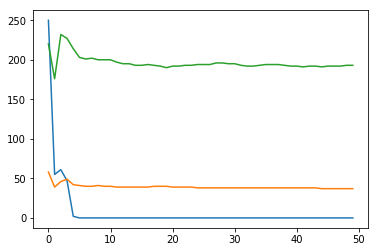

1


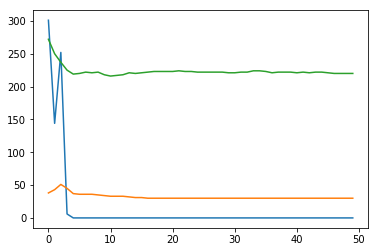

2


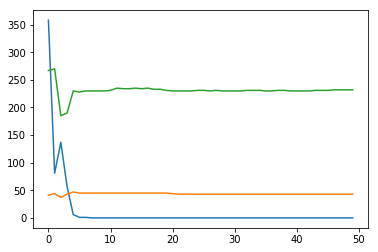

3


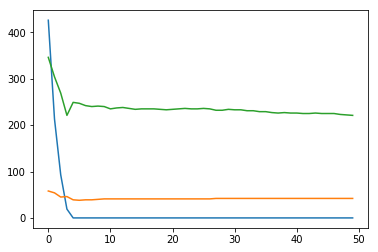

4


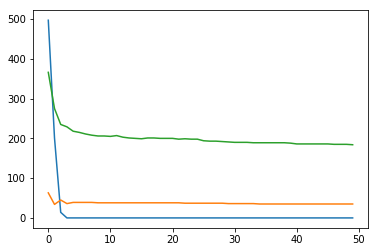

5


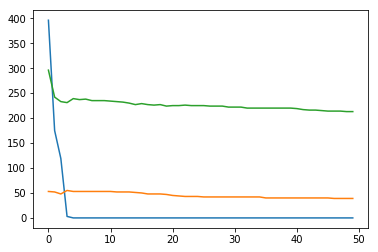

6


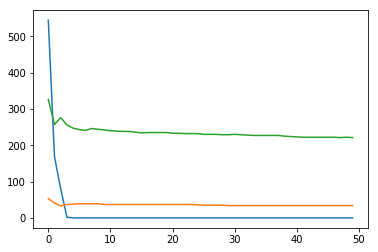

7


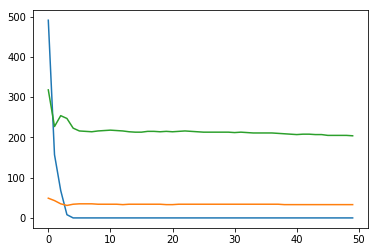

8


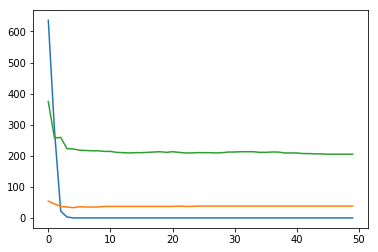

9


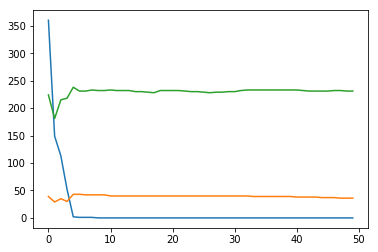

In [7]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


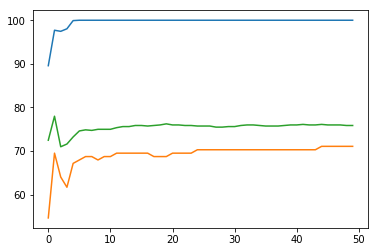

1


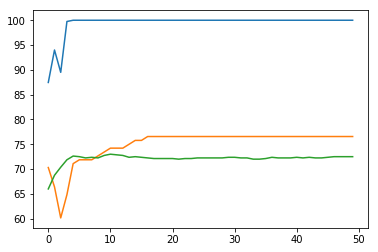

2


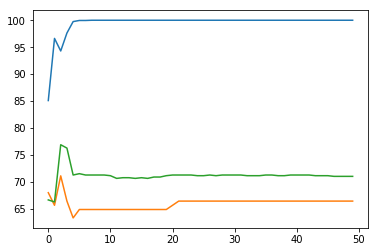

3


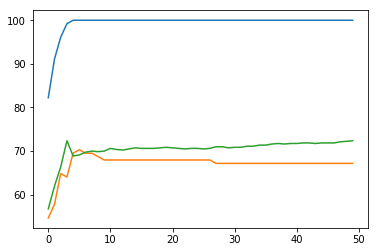

4


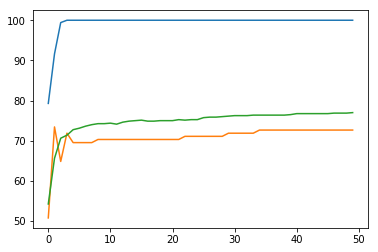

5


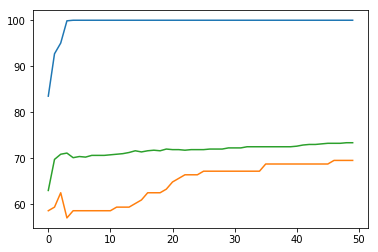

6


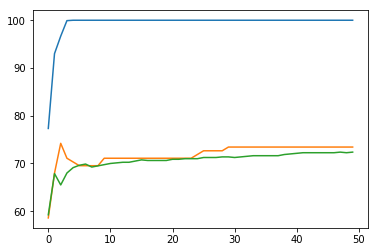

7


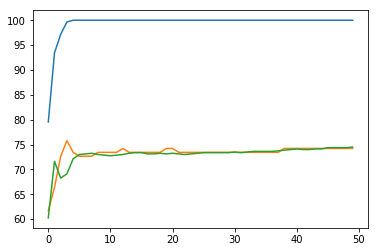

8


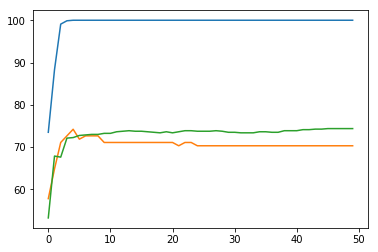

9


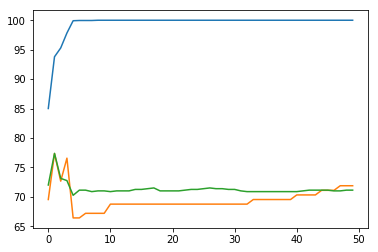

In [8]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

(50,)
Training accuracy  100%+-0.0
Validation accuracy 71.3%+-2.9656646251678467
Testing accuracy 73.4%+-1.872665286064148


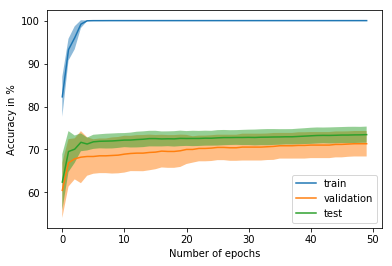

In [9]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(50))
print(stddev_train_errors.shape)

#plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
#plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
#plt.errorbar(epoch, mean_test_errors, stddev_test_errors)

plt.plot(epoch, mean_train_errors)
plt.plot(epoch, mean_val_errors)
plt.plot(epoch, mean_test_errors)
plt.fill_between(epoch, mean_train_errors+stddev_train_errors, mean_train_errors-stddev_train_errors, alpha=0.5)
plt.fill_between(epoch, mean_val_errors+stddev_val_errors, mean_val_errors-stddev_val_errors, alpha=0.5)
plt.fill_between(epoch, mean_test_errors+stddev_test_errors, mean_test_errors-stddev_test_errors, alpha=0.5)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])

print("Training accuracy {:4.3g}%+-{}".format(mean_train_errors[-1], stddev_train_errors[-1]))
print("Validation accuracy {:4.3g}%+-{}".format(mean_val_errors[-1], stddev_val_errors[-1]))
print("Testing accuracy {:4.3g}%+-{}".format(mean_test_errors[-1], stddev_test_errors[-1]))